In [ ]:
# 1) 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 2) Matplotlib에 폰트 적용
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 나눔고딕 경로 불러오기
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)

plt.rc('font', family='NanumGothic')     # 기본 폰트 지정
plt.rc('axes', unicode_minus=False)      # 마이너스 깨짐 방지

print("✓ 한글 폰트 설정 완료!")


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
✓ 한글 폰트 설정 완료!


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models


df = pd.read_csv("/content/lstm_dataset.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["pid", "date"]).reset_index(drop=True)

print(df.head())
print(df.columns)
print(df["pid"].nunique(), df["date"].min(), df["date"].max())


        date  month  day day_group  day_weight  season  pid         lon  \
0 2019-01-01      1    1      1~10        0.85  spring    0  129.158357   
1 2019-01-02      1    2      1~10        0.85  spring    0  129.158357   
2 2019-01-03      1    3      1~10        0.85  spring    0  129.158357   
3 2019-01-04      1    4      1~10        0.85  spring    0  129.158357   
4 2019-01-05      1    5      1~10        0.85  spring    0  129.158357   

         lat     Tmean  ...      WSPD     TP_mm  RNE  sunlight_era5      NDVI  \
0  35.787434 -2.327302  ...  4.339929  0.038618  1.0      11.290624  0.451376   
1  35.787434 -2.172745  ...  3.947368  0.016638  1.0      11.568688  0.451376   
2  35.787434 -2.075919  ...  2.109486  0.000852  1.0      11.551912  0.451376   
3  35.787434  1.575199  ...  2.882496  0.065391  1.0      10.343576  0.451376   
4  35.787434 -0.583995  ...  2.602061  0.013230  1.0      11.494980  0.451376   

     preDWI       DWI  FMI  TMI      FFDRI  
0  0.841382  0.84

## "계절 분리해서 FFDRI 모델링하는 것" 에 대한 합리적인 설명

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/lstm_dataset.csv")
df["date"] = pd.to_datetime(df["date"])
df["Month"] = df["date"].dt.month

# 월별 FFDRI 통계
monthly_stats = df.groupby("Month")["FFDRI"].agg([
    ("mean_FFDRI", "mean"),
    ("std_FFDRI", "std"),
    ("min_FFDRI", "min"),
    ("max_FFDRI", "max"),
    ("iqr_FFDRI", lambda x: x.quantile(0.75) - x.quantile(0.25)),
])

# Range 추가
monthly_stats["range_FFDRI"] = monthly_stats["max_FFDRI"] - monthly_stats["min_FFDRI"]

monthly_stats


,mean_FFDRI,std_FFDRI,min_FFDRI,max_FFDRI,iqr_FFDRI,range_FFDRI
Month,,,,,,
1,18.351234,5.007469,8.232734,27.853037,7.518025,19.620303
2,18.007114,4.994117,8.222219,27.836090,7.570466,19.613871
3,19.782755,5.659478,8.707103,32.315828,8.574018,23.608725
4,19.468117,5.653390,8.586332,32.344542,8.392716,23.758210
5,16.954049,5.001409,8.135414,27.471097,7.664777,19.335683
6,15.696177,4.697973,7.566807,25.784986,7.207413,18.218179
7,6.337752,1.942694,3.160664,10.701478,2.860863,7.540814
8,6.351393,1.932702,3.171979,10.654968,2.923511,7.482989
9,10.035191,2.948903,4.802792,16.260768,4.285979,11.457975


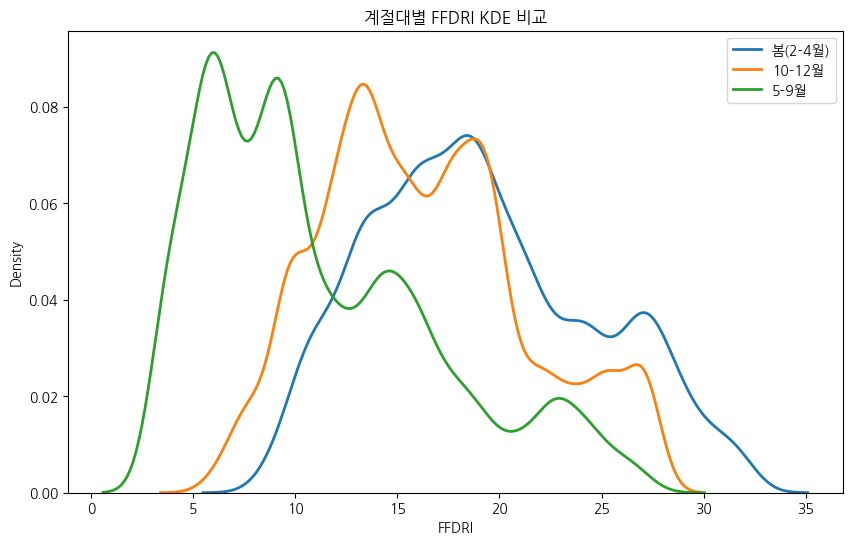

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df["Month"].isin([2,3,4])]["FFDRI"], label="봄(2–4월)", linewidth=2)
sns.kdeplot(df[df["Month"].isin([10,11,12])]["FFDRI"], label="10–12월", linewidth=2)
sns.kdeplot(df[df["Month"].isin([5,6,7,8,9])]["FFDRI"], label="5–9월", linewidth=2)
plt.title("계절대별 FFDRI KDE 비교")
plt.legend()
plt.show()


## 1차 모델링(FFDRI 기반 예측)

In [ ]:
df["Month"] = df["date"].dt.month

def season_category(m):
    if m in [2, 3, 4]:
        return 1  # 봄
    elif m in [10, 11, 12]:
        return 2  # 가을·겨울
    else:
        return 0  # 그 외

df["season_cat"] = df["Month"].apply(season_category)

df["season_cat"].value_counts()

,count
season_cat,
0,16560
2,8280
1,8040


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score


def make_sequences_by_pid(df_sub, feature_cols, target_col, seq_len=14):
    X_list, y_list = [], []

    for pid, g in df_sub.groupby("pid"):
        g = g.sort_values("date")
        values = g[feature_cols + [target_col]].values
        dates = g["date"].values

        if len(g) <= seq_len:
            continue

        for i in range(len(g) - seq_len):
            window_dates = dates[i:i+seq_len]
            diffs = (window_dates[1:] - window_dates[:-1]).astype("timedelta64[D]").astype(int)
            if not np.all(diffs == 1):
                continue

            X_list.append(values[i:i+seq_len, :-1])
            y_list.append(values[i+seq_len, -1])

    if len(X_list) == 0:
        return None, None
    return np.array(X_list), np.array(y_list)


def build_light_lstm(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(32),
        layers.Dense(8, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=["mae"]
    )
    return model


feature_cols = ["Tmean", "RH", "WSPD", "TP_mm", "sunlight_era5", "NDVI"]
target_col = "FFDRI"
seq_len = 14
split_date = pd.Timestamp("2024-01-01")
season_list = [1, 2]

quick_results = []


for target_season in season_list:
    print("=" * 60)
    print("SEASON", target_season)
    print("=" * 60)

    df_season = df[df["season_cat"] == target_season].copy()
    df_season["date"] = pd.to_datetime(df_season["date"])
    df_season = df_season.sort_values(["pid", "date"])

    train_df = df_season[df_season["date"] < split_date].copy()
    test_df = df_season[df_season["date"] >= split_date].copy()

    if len(train_df) < seq_len + 30 or len(test_df) < seq_len + 10:
        print("skip season", target_season)
        continue

    scaler = StandardScaler()
    train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
    test_df[feature_cols] = scaler.transform(test_df[feature_cols])

    X_train, y_train = make_sequences_by_pid(train_df, feature_cols, target_col, seq_len)
    X_test, y_test = make_sequences_by_pid(test_df, feature_cols, target_col, seq_len)

    if X_train is None or X_test is None:
        print("sequence insufficient")
        continue

    print("train:", X_train.shape, "test:", X_test.shape)

    model = build_light_lstm((X_train.shape[1], X_train.shape[2]))
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=12,
        batch_size=64,
        callbacks=[es],
        verbose=1
    )

    y_pred = model.predict(X_test).ravel()
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("MAE:", round(mae, 3), "R2:", round(r2, 3))

    quick_results.append({
        "season": target_season,
        "train_seq": len(X_train),
        "test_seq": len(X_test),
        "MAE": mae,
        "R2": r2
    })


quick_results_df = pd.DataFrame(quick_results)
quick_results_df


SEASON 1
train: (5700, 14, 6) test: (1140, 14, 6)
Epoch 1/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 360.7196 - mae: 18.1838 - val_loss: 214.2244 - val_mae: 13.5024
Epoch 2/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 103.8004 - mae: 8.4910 - val_loss: 38.9719 - val_mae: 4.7346
Epoch 3/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 29.7089 - mae: 4.4276 - val_loss: 32.7708 - val_mae: 4.6336
Epoch 4/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 29.5599 - mae: 4.4572 - val_loss: 32.7589 - val_mae: 4.6158
Epoch 5/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 30.0784 - mae: 4.4891 - val_loss: 31.9622 - val_mae: 4.5473
Epoch 6/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 30.3100 - mae: 4.5168 - val_loss: 31.6326 - val_mae: 4.5334
Epoch 7/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 28.8544 - mae: 4.3967 - val_loss: 31.5849 - val_mae: 4.5064
Epoch 8/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 29.8687 - mae: 4.4648 - val_loss: 30.9006 - val_mae: 4.4392


,season,train_seq,test_seq,MAE,R2
0,1,5700,1140,4.493492,0.080921
1,2,5910,1170,3.627369,0.245812


## 2차 모델링(dwi 기반 예측)
## DWI 예측 후, FFDRI 산출 공식에 따른 합산

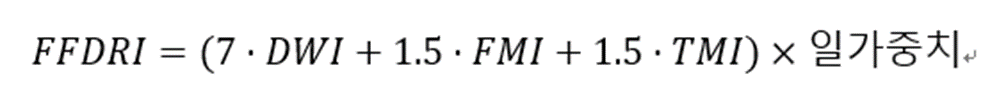

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/lstm_dataset_with_type.csv")
df["date"] = pd.to_datetime(df["date"])

# 타입 확인
print(df.columns)
print(df.head())



Index(['date', 'month', 'day', 'day_group', 'day_weight', 'season', 'pid',
       'lon', 'lat', 'Tmean', 'RH', 'EH', 'WSPD', 'TP_mm', 'RNE',
       'sunlight_era5', 'NDVI', 'preDWI', 'DWI', 'FMI', 'TMI', 'FFDRI',
       'type'],
      dtype='object')
        date  month  day day_group  day_weight  season  pid         lon  \
0 2019-01-01      1    1      1~10        0.85  spring    0  129.158357   
1 2019-01-02      1    2      1~10        0.85  spring    0  129.158357   
2 2019-01-03      1    3      1~10        0.85  spring    0  129.158357   
3 2019-01-04      1    4      1~10        0.85  spring    0  129.158357   
4 2019-01-05      1    5      1~10        0.85  spring    0  129.158357   

         lat     Tmean  ...     TP_mm  RNE  sunlight_era5      NDVI    preDWI  \
0  35.787434 -2.327302  ...  0.038618  1.0      11.290624  0.451376  0.841382   
1  35.787434 -2.172745  ...  0.016638  1.0      11.568688  0.451376  0.764884   
2  35.787434 -2.075919  ...  0.000852  1.0      11.5519

In [ ]:
# 계절(옵션 – feature로 쓸 수 있음)
df["Month"] = df["date"].dt.month

def season_category(m):
    if m in [2,3,4]:

        return 1  # 봄
    elif m in [10,11,12]:
        return 2  # 가을·겨울
    else:
        return 0  # 나머지
df["season_cat"] = df["Month"].apply(season_category)


In [ ]:
# 기상 + NDVI + 전일 DWI + 계절 + type one-hot
feature_cols = [
    "Tmean", "RH", "WSPD", "TP_mm", "sunlight_era5",
    "DWI",          # 과거 DWI들을 같이 사용
    "season_cat"
]

target_col = "DWI"   # '다음날 DWI'를 예측
aux_cols   = ["FMI", "TMI", "day_weight"]  # FFDRI 계산용


In [ ]:
def make_sequences(df_sub, feature_cols, target_col, aux_cols, seq_len=60):
    """
    df_sub: train 또는 test DataFrame (여러 pid 포함 가능)
    반환:
      X: (N, seq_len, num_features)
      y: (N,)  ← target_col (여기서는 DWI_next_day)
      aux: (N, len(aux_cols))  ← 해당 날짜의 FMI/TMI/day_weight
    """
    X_list, y_list, aux_list = [], [], []

    for pid, g in df_sub.groupby("pid"):
        g = g.sort_values("date")

        feat_vals = g[feature_cols].values
        target_vals = g[target_col].values
        aux_vals = g[aux_cols].values
        dates = g["date"].values

        if len(g) <= seq_len:
            continue

        for i in range(len(g) - seq_len):
            window_dates = dates[i:i+seq_len+1]  # 마지막이 y 날짜
            diffs = (window_dates[1:] - window_dates[:-1]).astype("timedelta64[D]").astype(int)

            # 하루씩 연속인지 확인
            if not np.all(diffs == 1):
                continue

            x_seq = feat_vals[i:i+seq_len]          # 과거 60일
            y_val = target_vals[i+seq_len]          # 그 다음날 DWI
            aux_val = aux_vals[i+seq_len]           # 그 날의 FMI,TMI,day_weight

            X_list.append(x_seq)
            y_list.append(y_val)
            aux_list.append(aux_val)

    if len(X_list) == 0:
        return None, None, None

    return np.array(X_list), np.array(y_list), np.array(aux_list)


In [ ]:
from sklearn.preprocessing import StandardScaler

seq_len    = 60
split_date = pd.Timestamp("2023-01-01")

# 시간 기준 스플릿
train_df = df[df["date"] < split_date].copy()
test_df  = df[df["date"] >= split_date].copy()

# 피처 스케일러 (train 기준)
x_scaler = StandardScaler()
train_df[feature_cols] = x_scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols]  = x_scaler.transform(test_df[feature_cols])

# 시퀀스 생성
X_train, y_train, aux_train = make_sequences(train_df, feature_cols, target_col, aux_cols, seq_len)
X_test,  y_test,  aux_test  = make_sequences(test_df,  feature_cols, target_col, aux_cols, seq_len)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (21015, 60, 7) X_test: (10065, 60, 7)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score

def build_lstm_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(32),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)
    ])

    model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=["mae"]
    )
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 0.6594 - mae: 0.6705 - val_loss: 0.5979 - val_mae: 0.6166
Epoch 2/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - loss: 0.5224 - mae: 0.5694 - val_loss: 0.5677 - val_mae: 0.5987
Epoch 3/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.4824 - mae: 0.5452 - val_loss: 0.5467 - val_mae: 0.5966
Epoch 4/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - loss: 0.4493 - mae: 0.5230 - val_loss: 0.5447 - val_mae: 0.5977
Epoch 5/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.4128 - mae: 0.4995 - val_loss: 0.5060 - val_mae: 0.5663
Epoch 6/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.3729 - mae: 0.4736 - val_loss: 0.5203 - val_mae: 0.5759
Epoch 7/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - loss: 0.3359 - mae: 0.4444 - val_loss: 0.4861 - val_mae: 0.5375
Epoch 8/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.3020 - mae: 0.4182 - val_loss: 0.4577 - val_mae: 0.5236
Epoch 9/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# 1) DWI 예측 (이미 학습된 model과 X_test 사용)
y_pred_dwi = model.predict(X_test).ravel()

y_true_dwi = y_test.copy()
y_pred_dwi_true = y_pred_dwi.copy()


assert len(y_true_dwi) == len(y_pred_dwi_true) == aux_test.shape[0], \
    f"length mismatch: y_true={len(y_true_dwi)}, y_pred={len(y_pred_dwi_true)}, aux={aux_test.shape[0]}"

print("=== DWI 예측 성능 ===")
print("MAE (DWI):", mean_absolute_error(y_true_dwi, y_pred_dwi_true))
print("R2  (DWI):", r2_score(y_true_dwi, y_pred_dwi_true))

# 2) FFDRI 계산 (DWI 예측 기반)
FMI_test        = aux_test[:, 0]
TMI_test        = aux_test[:, 1]
day_weight_test = aux_test[:, 2]

FFDRI_true = (y_true_dwi      + FMI_test + TMI_test) * day_weight_test
FFDRI_pred = (y_pred_dwi_true + FMI_test + TMI_test) * day_weight_test

print("\n=== FFDRI 예측 성능 (DWI 예측 기반) ===")
print("MAE (FFDRI):", mean_absolute_error(FFDRI_true, FFDRI_pred))
print("R2  (FFDRI):", r2_score(FFDRI_true, FFDRI_pred))


315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
=== DWI 예측 성능 ===
MAE (DWI): 0.7504261499147046
R2  (DWI): 0.07121992741441663

=== FFDRI 예측 성능 (DWI 예측 기반) ===
MAE (FFDRI): 0.5391195433729851
R2  (FFDRI): 0.9703780438100227
